In [24]:
import pickle
import numpy as np
from dnn_model import DNNModel
import torch
import tqdm

In [25]:
from importlib import reload
import dnn_model
reload(dnn_model)

<module 'dnn_model' from '/content/dnn_model.py'>

In [ ]:
DATA_FILE = 'data_large_multi_mpc (1).pkl'
MODEL_DIMENSIONS = [39, 128, 128, 64, 1]
OPPONENTS = {
    0: [2, 1],
    1: [2, 0], # Their's: 2, Ours: 1
    2: [0, 1]  # Their's: 1, Ours: 2
}
HIDDEN_WINDOW = 100
DISCOUNT_FACTOR = 0.99
N = 3
LR = 0.001
EPOCHS = 500
BATCH_SIZE = 32

data = pickle.load(open(DATA_FILE, 'rb'))

In [27]:
# data = np.array(data[:-1])  # Incomplete last episode
data.shape

(581, 241, 39)

In [28]:
def fix_difference(t):
    t = (t > 75.0435) * (t - 150.087) + (t < -75.0435) * (t + 150.087) + (t <= 75.0435) * (t >= -75.0435) * t
    return t

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using device: cuda


In [30]:
X = data[:,:,:].copy()
X[:,:,0] = data[:,:,2] - data[:,:,1]
X[:,:,1] -= data[:,:,0]
X[:,:,2] -= data[:,:,0]
for i in range(N):
    X[:,:,i] = fix_difference(X[:,:,i])

X = torch.tensor(X, dtype=torch.float32).to(device)

Y = torch.zeros((N, X.shape[0], X.shape[1]-1)).to(device)
for i in range(N):
    Y[i, :, :] = torch.maximum(X[:, 1:, OPPONENTS[i][0]], X[:, 1:, OPPONENTS[i][1]]) - torch.maximum(X[:, :-1, OPPONENTS[i][0]], X[:, :-1, OPPONENTS[i][1]])
    Y[i, :, :] = fix_difference(Y[i, :, :])

rewards = torch.zeros(N, X.shape[0], Y.shape[2]-HIDDEN_WINDOW).to(device)
masks = []

for j in range(N):
    for i in range(0, HIDDEN_WINDOW):
        rewards[j, :, :] += (DISCOUNT_FACTOR**i) * Y[j, :, i:i+Y.shape[2]-HIDDEN_WINDOW]

    masks.append(torch.tensor((rewards[j] < 600.) * (rewards[j] >= -100.)).to(device))

/tmp/ipython-input-3760218292.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks.append(torch.tensor((rewards[j] < 600.) * (rewards[j] >= -100.)).to(device))


In [31]:
models = [DNNModel(MODEL_DIMENSIONS).to(device) for _ in range(N)]
optimizers = [torch.optim.Adam(model.parameters(), lr=LR) for model in models]
loss_fn = torch.nn.MSELoss()

In [32]:
from tqdm.notebook import tqdm

epoch_losses = [[] for _ in range(N)]

epoch_tqdm = tqdm(range(EPOCHS), position=0, dynamic_ncols=True, desc="Epochs")

for e in epoch_tqdm:
    total_loss = [0.0] * N
    num_batches = 0
    batches = range(0, len(X) - BATCH_SIZE + 1, BATCH_SIZE)

    with tqdm(batches, position=e+1, leave=True, dynamic_ncols=True, mininterval=0.2, desc=f"Epoch {e+1}/{EPOCHS}") as batch_tqdm:
        for j in batch_tqdm:
            x_batch = X[j:j+BATCH_SIZE, :-HIDDEN_WINDOW-1, :]
            for i in range(N):
                y_batch = rewards[i, j:j+BATCH_SIZE, :]
                mask = masks[i][j:j+BATCH_SIZE, :]

                optimizers[i].zero_grad()
                preds = models[i](x_batch).squeeze()
                loss = loss_fn(preds * mask, y_batch * mask)
                loss.backward()
                optimizers[i].step()

                total_loss[i] += loss.item()

            num_batches += 1

            avg_loss_so_far = [total_loss[i] / num_batches for i in range(N)]
            postfix = {"epoch": e+1}
            postfix.update({f"loss{i}": f"{avg:.4f}" for i, avg in enumerate(avg_loss_so_far)})
            batch_tqdm.set_postfix(postfix)

    avg_epoch_loss = [loss / num_batches for loss in total_loss]
    for i in range(N):
        epoch_losses[i].append(avg_epoch_loss[i])

    epoch_tqdm.set_postfix({f"loss{i}": f"{avg:.4f}" for i, avg in enumerate(avg_epoch_loss)})


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 81/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 86/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 91/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 96/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 101/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 106/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 111/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 116/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 121/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 126/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 131/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 136/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 141/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 146/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 151/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 156/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 161/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 166/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 171/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 176/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 181/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 186/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 189/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 190/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 191/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 192/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 193/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 194/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 195/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 196/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 197/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 198/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 199/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 200/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 201/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 202/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 203/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 204/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 205/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 206/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 207/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 208/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 209/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 210/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 211/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 212/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 213/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 214/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 215/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 216/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 217/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 218/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 219/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 220/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 221/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 222/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 223/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 224/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 225/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 226/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 227/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 228/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 229/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 230/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 231/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 232/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 233/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 234/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 235/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 236/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 237/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 238/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 239/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 240/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 241/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 242/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 243/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 244/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 245/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 246/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 247/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 248/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 249/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 250/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 251/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 252/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 253/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 254/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 255/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 256/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 257/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 258/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 259/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 260/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 261/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 262/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 263/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 264/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 265/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 266/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 267/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 268/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 269/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 270/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 271/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 272/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 273/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 274/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 275/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 276/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 277/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 278/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 279/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 280/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 281/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 282/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 283/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 284/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 285/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 286/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 287/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 288/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 289/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 290/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 291/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 292/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 293/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 294/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 295/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 296/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 297/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 298/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 299/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 300/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 301/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 302/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 303/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 304/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 305/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 306/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 307/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 308/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 309/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 310/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 311/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 312/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 313/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 314/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 315/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 316/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 317/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 318/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 319/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 320/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 321/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 322/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 323/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 324/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 325/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 326/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 327/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 328/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 329/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 330/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 331/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 332/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 333/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 334/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 335/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 336/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 337/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 338/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 339/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 340/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 341/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 342/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 343/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 344/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 345/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 346/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 347/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 348/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 349/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 350/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 351/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 352/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 353/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 354/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 355/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 356/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 357/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 358/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 359/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 360/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 361/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 362/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 363/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 364/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 365/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 366/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 367/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 368/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 369/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 370/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 371/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 372/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 373/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 374/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 375/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 376/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 377/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 378/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 379/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 380/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 381/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 382/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 383/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 384/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 385/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 386/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 387/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 388/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 389/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 390/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 391/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 392/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 393/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 394/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 395/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 396/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 397/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 398/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 399/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 400/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 401/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 402/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 403/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 404/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 405/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 406/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 407/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 408/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 409/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 410/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 411/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 412/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 413/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 414/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 415/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 416/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 417/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 418/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 419/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 420/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 421/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 422/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 423/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 424/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 425/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 426/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 427/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 428/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 429/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 430/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 431/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 432/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 433/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 434/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 435/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 436/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 437/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 438/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 439/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 440/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 441/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 442/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 443/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 444/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 445/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 446/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 447/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 448/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 449/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 450/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 451/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 452/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 453/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 454/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 455/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 456/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 457/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 458/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 459/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 460/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 461/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 462/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 463/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 464/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 465/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 466/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 467/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 468/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 469/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 470/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 471/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 472/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 473/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 474/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 475/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 476/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 477/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 478/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 479/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 480/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 481/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 482/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 483/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 484/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 485/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 486/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 487/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 488/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 489/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 490/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 491/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 492/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 493/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 494/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 495/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 496/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 497/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 498/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 499/500:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 500/500:   0%|          | 0/18 [00:00<?, ?it/s]

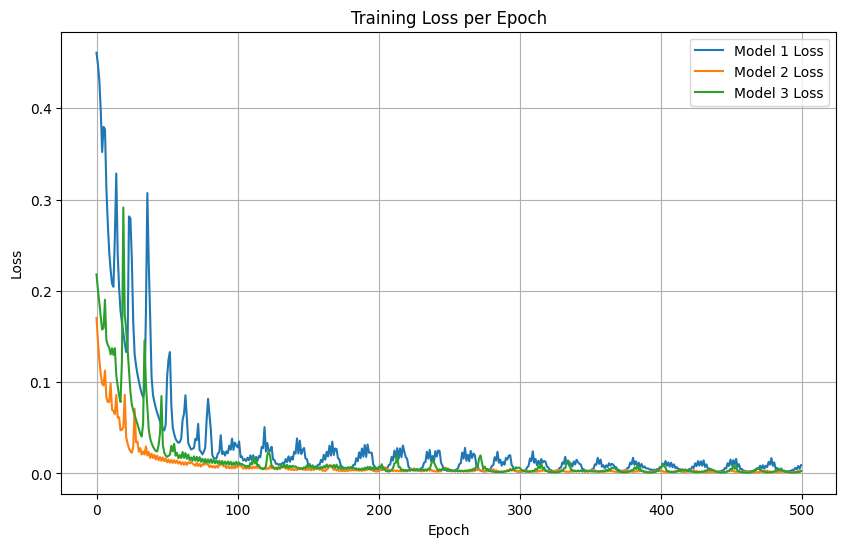

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(epoch_losses[i], label=f'Model {i+1} Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
for i in range(N):
    torch.save(models[i].state_dict(), f'value_model_{i}.pth')

In [36]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashukla-24 (mahin-sank-iit-kgp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [37]:
wandb.init(project='q-model-training', name='Value Model Training Run')

In [38]:
artifact = wandb.Artifact('trained-models', type='model')

for i in range(N):
    model_path = f'value_model_{i}.pth'
    torch.save(models[i].state_dict(), model_path)
    artifact.add_file(model_path)

wandb.log_artifact(artifact)

<Artifact trained-models>